In [1]:
from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Load Modules and Data

In [2]:
!pip install tensorflow_hub
!pip install split-folders

# Helper scripts
from google_colab_utils import *

import os
import glob
import shutil
import splitfolders
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import itertools

# Sklearn
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

# TensorFlow
import tensorflow_hub as hub
import tensorflow_addons as tfa
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dropout , BatchNormalization
from tensorflow.keras import regularizers

# Check correct version off TensorFlow
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')

TensorFlow version: 2.3.0


In [3]:
# Fetch Dataset
API_TOKEN = {"username":"littleotter","key":"b952707737a70884d1d2a8a200709c56"}
URL = 'https://www.kaggle.com/ikarus777/best-artworks-of-all-time'
download_kaggle_dataset(URL, API_TOKEN)

Setting up Kaggle for Google Colab...


In [4]:
print(f"""
Folder: 'images':
Number of classes: {len(os.listdir('images/images/'))}
Sample of classes: {os.listdir('images/images/')[:5]}

Folder: 'resized':
Number of files: {len(os.listdir('resized/resized/'))}
Sample of files: {os.listdir('resized/resized/')[:5]}
""")


Folder: 'images':
Number of classes: 51
Sample of classes: ['Gustave_Courbet', 'Frida_Kahlo', 'Pieter_Bruegel', 'Leonardo_da_Vinci', 'Peter_Paul_Rubens']

Folder: 'resized':
Number of files: 8683
Sample of files: ['Edouard_Manet_22.jpg', 'Pierre-Auguste_Renoir_225.jpg', 'Edgar_Degas_461.jpg', 'Diego_Rivera_59.jpg', 'Edgar_Degas_513.jpg']



In [5]:
# Peek at the data
df_artists = pd.read_csv('artists.csv')
df_artists.head(5)

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


# Prepare data

In [6]:
def artist_from_image(image, artist_name_mapping):
    """Extracts the artist name from a .jpg path
    
    Arg:
        image: filepath of an image
        
    Return:
        returns the arist name
    """
    return artist_name_mapping[' '.join(image.split('_')[:-1])]

In [7]:
# Create directory paths
print("Creating directory paths...")
DIR = 'dataset/'
TEMP_DIR = 'tmp/'
ARTISTS_DIR = 'images/images/'
ARTWORK_DIR = 'resized/resized/'
MODEL_DIR = 'model_dir/'
CHECKPOINT_DIR = 'model_dir/checkpoint'
WEIGHTS_DIR = 'model_dir/final_weights'

# Get list of artists and their artwork
artists = [artist.replace('_', ' ') for artist in os.listdir(ARTISTS_DIR)]
images = os.listdir(ARTWORK_DIR)

# Mapping to correct artist text
pre_artist = sorted(artists)
post_artist = sorted(list(df_artists['name']))
post_artist = post_artist[:1] + post_artist
artist_name_mapping = dict(zip(pre_artist, post_artist))

# Create temporary directory structures
os.mkdir(MODEL_DIR)
os.mkdir(CHECKPOINT_DIR)
os.mkdir(WEIGHTS_DIR)
os.mkdir(TEMP_DIR)
for artist in artists:
  try:
    path = os.path.join(TEMP_DIR, artist_name_mapping[artist])
    os.mkdir(path)
  except:
    pass

# Copy images into the directories of their respective artist
for image in images:
    src = os.path.join(ARTWORK_DIR, image)
    dst = os.path.join(TEMP_DIR, artist_from_image(image, artist_name_mapping), image)
    shutil.copy(src, dst)
    
# Split data
splitfolders.ratio(TEMP_DIR, output=DIR, seed=1337, ratio=(.85, .1, .05), group_prefix=None)

# Remove tmp directory to clear up space
shutil. rmtree('tmp')

Creating directory paths...


Copying files: 8683 files [00:20, 430.61 files/s]


In [8]:
# Hyperparameters
BATCH_SIZE = 64
IMAGE_SIZE = 224
EPOCHS = 500
FINE_TUNE_EPOCHS = 500
BASE_LEARNING_RATE = 0.001

# The pre-trained model MobileNet V2 expects pixel vaues in [-1,1] so use the model's preprocess_input to scale the images
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Training Image Generator
TRAIN_DIR = os.path.join(DIR, 'train')
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range = 45,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    target_size = (IMAGE_SIZE, IMAGE_SIZE)
)

# Validation Image Generator
VAL_DIR = os.path.join(DIR, 'val')
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    target_size = (IMAGE_SIZE, IMAGE_SIZE)
)

# Test Image Generator
TEST_DIR = os.path.join(DIR, 'test')
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True
)

# Sample Image Generator
sample_test_datagen = ImageDataGenerator(rescale=1./255)
sample_test_generator = sample_test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    shuffle=False
)

Found 7356 images belonging to 50 classes.
Found 845 images belonging to 50 classes.
Found 482 images belonging to 50 classes.
Found 482 images belonging to 50 classes.


# Define Model and Metrics

## Metrics

In [9]:
# Initialize Metrics
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tfa.metrics.F1Score(num_classes=51, average='micro')
]

## Feature Extraction

Create a convolutional base from the pre-trained model MobileNet V2 and freeze it to use as a feature extractor. It is important to freeze the convolutional base before you compile and train the model. Additionally, add a classifier on top of it to train the top-level classifier.



Add a classification head to generate predictions from the block of features by averaging over the spatial 5x5 spatial locations and using a GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image. Add a dropout layer then apply a Dense layer to convert these features into a single prediction per image. 

In [10]:

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE) + (3,),
                                              include_top=False, # Don't include the fully-connected layer at the top of the network
                                              weights='imagenet')
# Freeze the convolutional base
base_model.trainable = False

# Build the Model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(os.listdir(TRAIN_DIR)), activation='softmax')
])

# Compile the Model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=BASE_LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=METRICS)



9412608/9406464 [==============================] - 0s 0us/step


## Class Weights

In [11]:
# Get the number of paintings for each artist in training
paintings_count = {}
for artist in os.listdir(TRAIN_DIR):
  paintings_count[artist] = len(glob.glob1(os.path.join(TRAIN_DIR, artist),"*.jpg"))

total = sum(paintings_count.values())
class_count = len(paintings_count)

# Calculate class weights
class_weights = {}
for i, artist in enumerate(sorted(os.listdir(TRAIN_DIR))):
  weight = (1 / paintings_count[artist]) * total / class_count
  class_weights[i] = weight

## Callbacks

In [12]:
# Initialize callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='f1_score',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

reduce_lr_on_plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='f1_score',
    factor=0.2,
    patience=5)

checkpoint_filepath = os.path.join(CHECKPOINT_DIR, 'checkpoint')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='f1_score',
    save_best_only=True)

## Helper Functions for plots

In [13]:
def plot_metrics(history, segment=None):
  """Plot metrics

  Arg:
    history: history or dictionary object containing the metrics during training
    segment: integer for which epoch to show the segment line
  """

  # Get epoch range
  if type(history) == dict:
      epoch = list(range(len(history['loss'])))
  else:
      epoch = list(range(history.epoch[-1] + 1))

  # Metrics 
  metrics = ['f1_score', 'recall', 'accuracy', 'precision', 'loss']
  plt.figure(figsize=(20,10))

  for i, metric in enumerate(metrics):

    # Plot metric for train and validation
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2, 3, i+1)
    if type(history) == dict:
        plt.plot(epoch,  history[metric], color='b', label='Train')
        plt.plot(epoch, history['val_'+metric],
                color='orangered', label='Val')
    else:
        plt.plot(epoch,  history.history[metric], color='b', label='Train')
        plt.plot(epoch, history.history['val_'+metric],
                color='orangered', label='Val')
        
    # Plot segment line
    if segment:
        plt.plot([segment,segment], 
          plt.ylim(), color='g', label='Start Fine Tuning')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.title(f"{metric.capitalize()} vs. Epoch")
    plt.legend()

In [14]:
def plot_cm(y_true, y_pred):
  """Plot Confusion Matrix

  Arg:
    y_true: list of true labels
    y_pred: list of predicted labels
  """
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(28, 16))
  sns.heatmap(cm, cmap=sns.color_palette("Blues"), linewidths=.5, cbar=False, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(.5))
  plt.yticks(list(class_names.keys()), list(class_names.values()), rotation=0)
  plt.xticks(list(class_names.keys()), list(class_names.values()), rotation=55)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

# Training

## Baseline

In [15]:
# Fit the model on the training data
history = model.fit(train_generator,
                    epochs = EPOCHS,
                    validation_data = val_generator,
                    callbacks=[early_stopping_callback,
                               reduce_lr_on_plateau_callback,
                               model_checkpoint_callback],
                    class_weight=class_weights)

Epoch 1/500
115/115 [==============================] - 122s 1s/step - loss: 3.3258 - tp: 282.0000 - fp: 133.0000 - tn: 360311.0000 - fn: 7074.0000 - accuracy: 0.2019 - precision: 0.6795 - recall: 0.0383 - f1_score: 0.2019 - val_loss: 2.4973 - val_tp: 70.0000 - val_fp: 22.0000 - val_tn: 41383.0000 - val_fn: 775.0000 - val_accuracy: 0.3408 - val_precision: 0.7609 - val_recall: 0.0828 - val_f1_score: 0.3408
Epoch 2/500
115/115 [==============================] - 120s 1s/step - loss: 2.2065 - tp: 1270.0000 - fp: 415.0000 - tn: 360029.0000 - fn: 6086.0000 - accuracy: 0.4073 - precision: 0.7537 - recall: 0.1726 - f1_score: 0.4073 - val_loss: 2.0417 - val_tp: 163.0000 - val_fp: 36.0000 - val_tn: 41369.0000 - val_fn: 682.0000 - val_accuracy: 0.4485 - val_precision: 0.8191 - val_recall: 0.1929 - val_f1_score: 0.4485
Epoch 3/500
115/115 [==============================] - 121s 1s/step - loss: 1.8470 - tp: 1856.0000 - fp: 551.0000 - tn: 359893.0000 - fn: 5500.0000 - accuracy: 0.4762 - precision: 0.

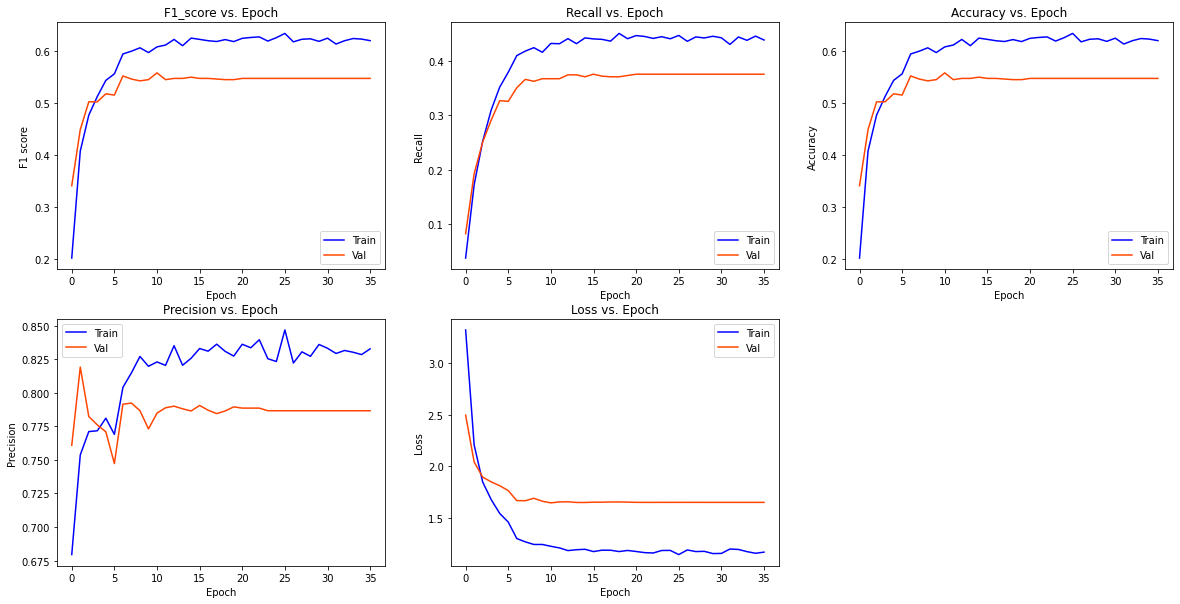

In [16]:
# Plot metrics
plot_metrics(history)

## Fine Tuning

During the feature extraction, only a few layers were trained on top of the MobileNet V2 base model. Though the weights of the pre-trained network were not updated during training.

In order to increase performance even further, "fine-tune" the weights of the top layers of the pre-trained model alongside the training of the classifier. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.


#### *Note This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.*

---

Unfreeze base_model and set the bottom layers to be un-trainable. Then, recompile the model and resume training in order to adapt MobileNet's specialized features to work with the new dataset.

In [17]:
# Unfreeze base model
base_model.trainable = True

# Examine many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  4


Since we are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, the model could overfit very quickly.

In [18]:
# Compile the Model
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=BASE_LEARNING_RATE * .1),
              metrics=METRICS)

# Examine model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                64050     
Total params: 2,322,034
Trainable params: 1,926,642
Non-trainable params: 395,392
_________________________________________________________________


In [19]:
print(f"Trainable variables: {len(model.trainable_variables)}")

Trainable variables: 58


# Continue training the model

In [20]:
# Total epochs
TOTAL_EPOCHS = EPOCHS + FINE_TUNE_EPOCHS

# Fit model
history_fine = model.fit(train_generator,
                         epochs=TOTAL_EPOCHS,
                         initial_epoch=history.epoch[-1] + 1,
                         validation_data=val_generator,
                         callbacks=[early_stopping_callback,
                                    reduce_lr_on_plateau_callback,
                                    model_checkpoint_callback],
                         class_weight=class_weights)

Epoch 37/1000
115/115 [==============================] - 133s 1s/step - loss: 1.5559 - tp: 2603.0000 - fp: 707.0000 - tn: 401142.0000 - fn: 5598.0000 - accuracy: 0.5290 - precision: 0.7864 - recall: 0.3174 - f1_score: 0.5290 - val_loss: 1.6561 - val_tp: 395.0000 - val_fp: 157.0000 - val_tn: 41248.0000 - val_fn: 450.0000 - val_accuracy: 0.5598 - val_precision: 0.7156 - val_recall: 0.4675 - val_f1_score: 0.5598
Epoch 38/1000
115/115 [==============================] - 131s 1s/step - loss: 1.1233 - tp: 3382.0000 - fp: 679.0000 - tn: 359765.0000 - fn: 3974.0000 - accuracy: 0.6383 - precision: 0.8328 - recall: 0.4598 - f1_score: 0.6383 - val_loss: 1.4717 - val_tp: 427.0000 - val_fp: 157.0000 - val_tn: 41248.0000 - val_fn: 418.0000 - val_accuracy: 0.6083 - val_precision: 0.7312 - val_recall: 0.5053 - val_f1_score: 0.6083
Epoch 39/1000
115/115 [==============================] - 131s 1s/step - loss: 0.8947 - tp: 3971.0000 - fp: 680.0000 - tn: 359764.0000 - fn: 3385.0000 - accuracy: 0.6841 - pre

In [21]:
# Combine metric scores from before and after fine tuning
accumulated_history = {}
for metric in history.history.keys():
  accumulated_history[metric] = history.history[metric] + history_fine.history[metric]


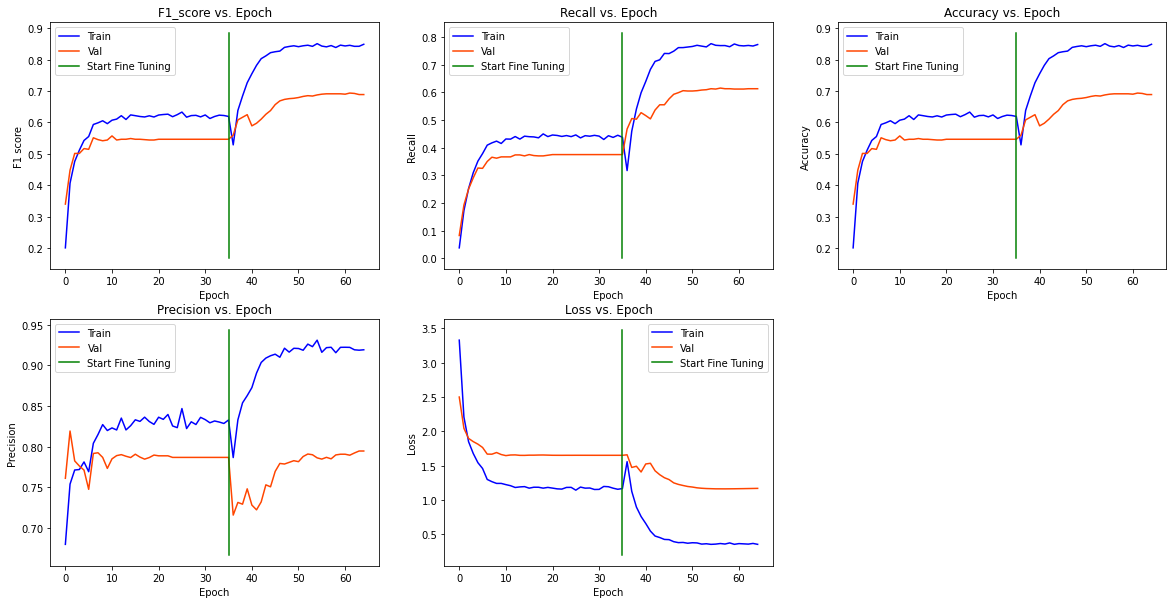

In [22]:
plot_metrics(accumulated_history, segment=history.epoch[-1])

# Evaluation and prediction

In [23]:
# Map indicies to class names
class_names = {k: v for k, v in enumerate(sorted(os.listdir(TRAIN_DIR)))}

## Model performance on test set

In [24]:
# Evaulate model on test set
model_results = model.evaluate(test_generator)

# Print metrics
print()
for i, (name, value) in enumerate(zip(model.metrics_names, model_results)):
  print(f"{name} :  {value}")

8/8 [==============================] - 3s 388ms/step - loss: 1.3188 - tp: 283.0000 - fp: 89.0000 - tn: 23529.0000 - fn: 199.0000 - accuracy: 0.6494 - precision: 0.7608 - recall: 0.5871 - f1_score: 0.6494

loss :  1.3187789916992188
tp :  283.0
fp :  89.0
tn :  23529.0
fn :  199.0
accuracy :  0.6493775844573975
precision :  0.7607526779174805
recall :  0.5871369242668152
f1_score :  0.6493775844573975


## Confusion Matrix

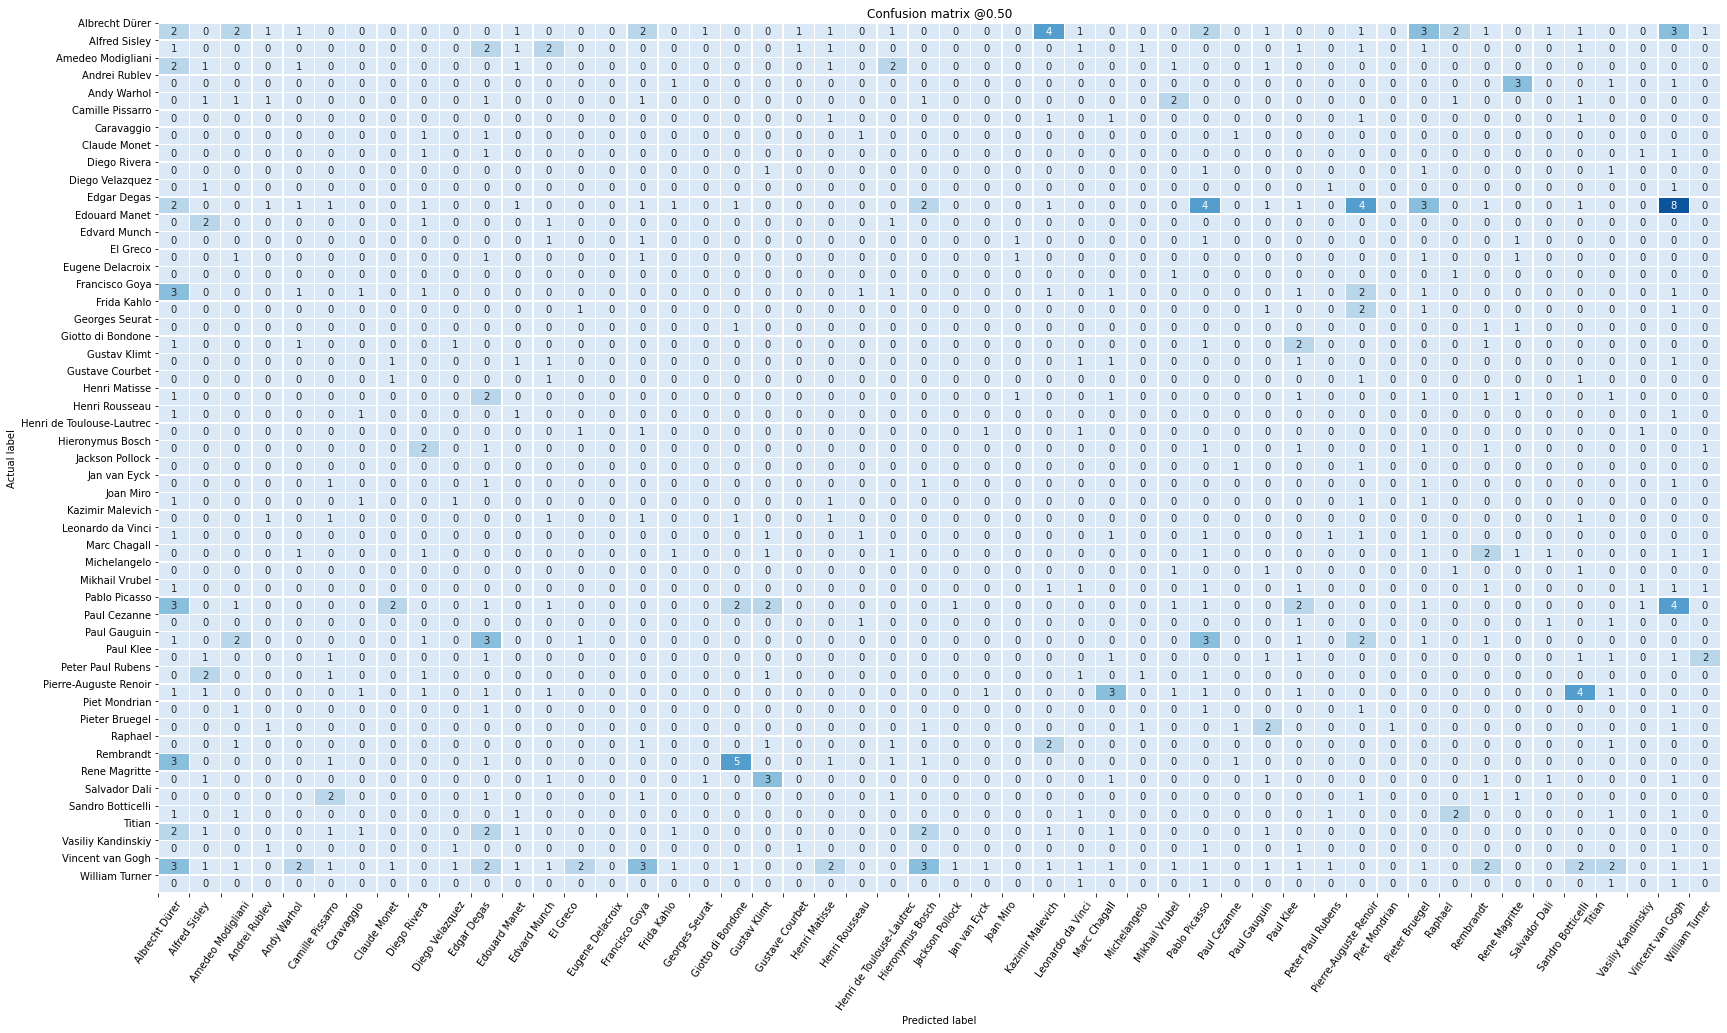

In [25]:
# True labels
y_true = test_generator.classes

# Predicted Labels
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Plot confusion matrix
plot_cm(y_true, y_pred)

In [26]:
# Fetch all images and labels from test set
test_batch_images = []
test_batch_labels = []

for i, v in enumerate(sample_test_generator):
  if i == len(sample_test_generator):
    break
  batch_images, batch_labels = v
  test_batch_images.append(batch_images)
  test_batch_labels.append(batch_labels)
  
# Flatten lists of lists into singular lists
test_batch_images = list(itertools.chain.from_iterable(test_batch_images))
test_batch_labels = list(itertools.chain.from_iterable(test_batch_labels))

# True labels
sample_y_true = sample_test_generator.classes

# Predicted Labels
sample_y_pred = model.predict(sample_test_generator)
sample_y_pred = np.argmax(sample_y_pred, axis=1)

# Shuffle images, labels, and predictions
test_batch_images, sample_y_pred, sample_y_true = shuffle(test_batch_images, sample_y_pred, sample_y_true)

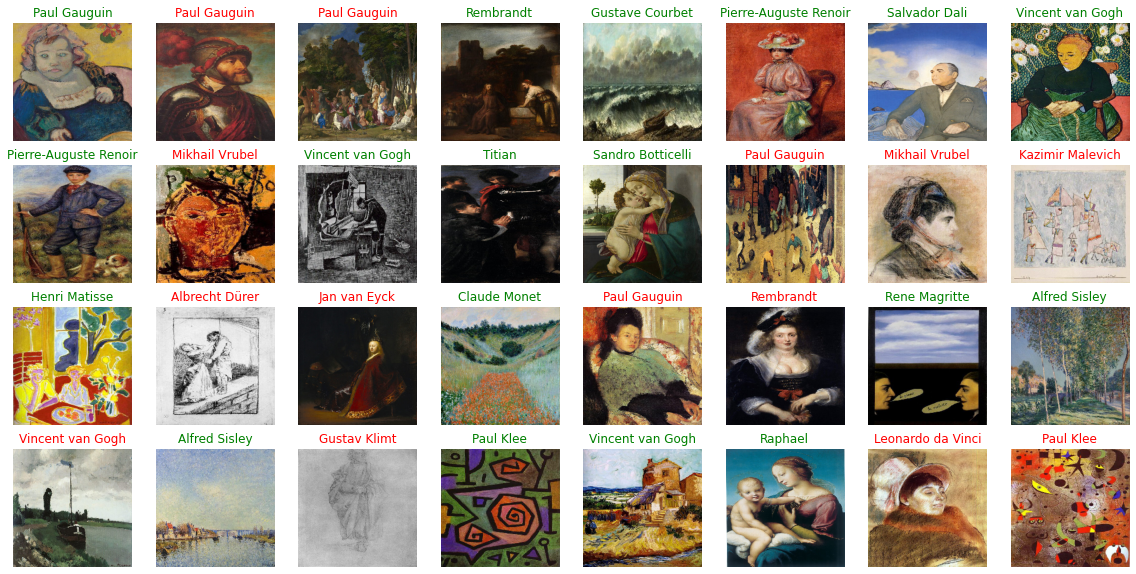

In [27]:
# Plot batch of images
plt.figure(figsize=(20, 10))
for i in range(32):
    # Color title according to prediction accuracy
    
    if sample_y_pred[i] == sample_y_true[i]:
        plt.rcParams.update({"text.color" : "green"})
    else:
        plt.rcParams.update({"text.color" : "red"})
        
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(test_batch_images[i])
    plt.title(class_names[sample_y_pred[i]])
    plt.axis("off")

# Save Model

In [28]:
# Save Model
FINAL_MODEL_PATH = os.path.join(MODEL_DIR, 'final_model')
FINAL_WEIGHTS_PATH = os.path.join(WEIGHTS_DIR, 'final_weights')

# Save Model and Weights
model.save(FINAL_MODEL_PATH)
model.save_weights(FINAL_WEIGHTS_PATH)

# Zip model directory
shutil.make_archive('final_model_weights', 'zip', 'model_dir')

# Download model directory
files.download('/content/final_model_weights.zip') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_dir/final_model/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>